In [ ]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
mnist = fetch_openml('mnist_784', version=1)

## Data Prepare

In [ ]:
X, y = mnist['data'], mnist['target']

5


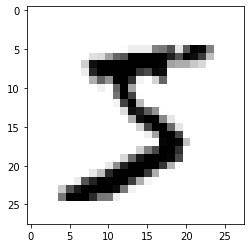

In [ ]:
__index=0
some_digit = X[__index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')

print(y[__index])
plt.show()

In [ ]:
y = y.astype(np.int8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## Classifier

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42).fit(X_train, y_train_5)

### SGDClassifier

In [ ]:
# Own Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

scores = []
skfolds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    X_train_folds = X_train[train_index]
    y_train_5_folds = y_train_5[train_index]

    X_test_folds = X_train[test_index]
    y_test_5_folds = y_train_5[test_index]

    clone_clf = clone(sgd_clf).fit(X_train_folds, y_train_5_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = np.sum(y_pred == y_test_5_folds)
    acc = n_correct/len(y_pred)

    print(acc)

    scores.append(acc)

In [ ]:
np.mean(scores), np.std(scores)

(0.9635666666666667, 0.0066654998978988005)

In [ ]:
# Cross-Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf, X_train, y_train_5, scoring='accuracy', cv=3)
scores

### Dumb custom clasifier

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Never5Classifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

scores = cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring='accuracy')
scores

array([0.90965, 0.90965, 0.90965])

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
confusion_matrix(y_train_5_pred, y_train_5)

array([[53892,  1891],
       [  687,  3530]])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_5_pred), recall_score(y_train_5, y_train_5_pred), f1_score(y_train_5, y_train_5_pred)

(0.8370879772350012, 0.6511713705958311, 0.7325171197343846)

### Precision-Recall curve

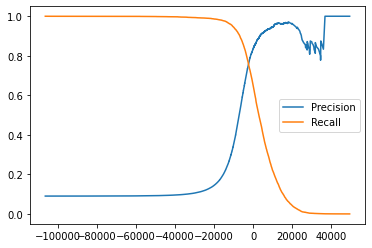

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_treshhold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')

    plt.legend()

    plt.show()

plot_precision_recall_vs_treshhold(precisions, recalls, thresholds)

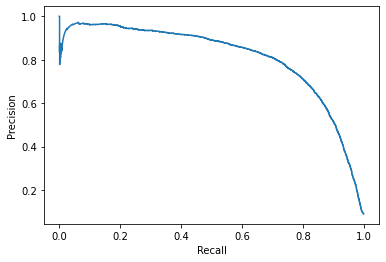

In [ ]:
plt.plot(recalls, precisions)

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

### ROC curve

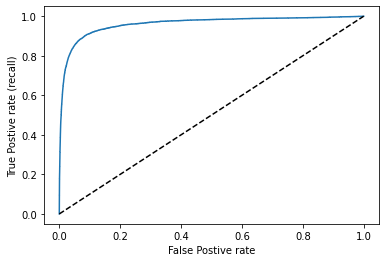

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlabel('False Postive rate')
    plt.ylabel('True Postive rate (recall)')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores) # Near 1 is better

0.9604938554008616

### Compare ROC curve anr ROC AUC score

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

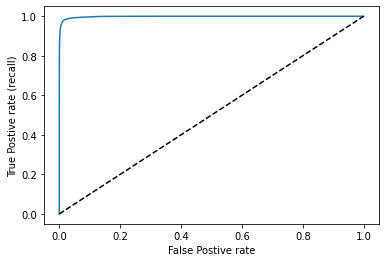

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # Probability of positive class
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores_forest)

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classifier

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
# One Vs Rest Classifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# cross_val_score(svm_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

## Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier().fit(X_train, y_multilabel)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)